In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import os
import sys
# Needed for the model class to work inside a Notebook.
os.environ["COBAYA_NOMPI"] = "True"
# Add everything to our paths.
repo = "/global/cscratch1/sd/mwhite/AnalyzeLAE/Cobaya/"
for codedir in ["lss_likelihood"]:
    sys.path.append(repo+codedir)

In [3]:
# GetDist is resetting the matplotlib backend to 'agg',
# which screws up inline plots.  To get around this we
# need to save the backend here and then reset it.
saved_backend = plt.rcParams["backend"]

In [4]:
from scipy.interpolate import UnivariateSpline as SmoothingSpline

In [5]:
from cobaya.yaml          import yaml_load_file
from cobaya.samplers.mcmc import plot_progress
from cobaya.model         import get_model
#
from getdist.mcsamples    import MCSamplesFromCobaya
from getdist.mcsamples    import loadMCSamples
import getdist.plots      as     gdplt
#
matplotlib.use(saved_backend)

### Let's take a look at some chains

In [6]:
db   = "/global/cscratch1/sd/mwhite/AnalyzeLAE/Cobaya/"
info = yaml_load_file(db + "lae_test.yaml")
print(info['params'].keys())
print(info['output'])

dict_keys(['b1', 'b2', 'bs', 'alpha0', 'alpha2', 'SN0', 'SN2'])
chains/lae_test


In [7]:
#
chains = []
clist  = []
llist  = []
legnd  = []
icol   = 0
for yaml in [\
            "lae_test.yaml",\
            ]:
    info= yaml_load_file(db + yaml)
    cc  = loadMCSamples(db + info["output"],no_cache=True,\
                        settings={'ignore_rows':0.3})
    #cc.weighted_thin(4)
    #p   = cc.getParams()
    #cc.addDerived(p.sigma8*(p.omegam/0.3)**0.5,name='S8',label='S_8')
    chains.append(cc)
    #
    col = 'C'+str(icol)
    clist.append(col)
    llist.append({'ls':'-','color':col})
    legnd.append(yaml[:-5])
    icol += 1
#
for cc in chains:
    print('\n'+cc.getName())
    #print("R-1=",cc.getGelmanRubin())
    print("Eff. samples ",cc.getEffectiveSamples())
    for k in ["b1","SN0"]:
        print( cc.getInlineLatex(k) )


lae_test
Eff. samples  2164.04974230371
b_1 = 0.991\pm 0.095
SN_0 = 1012\pm 200


In [8]:
#for cc in chains:
#    print(cc.getNumSampleSummaryText())

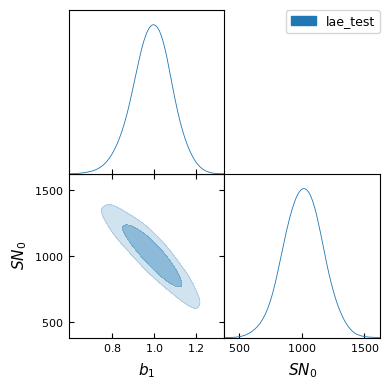

In [9]:
# Do the corner plot.
g = gdplt.get_subplot_plotter()
g.triangle_plot(chains,\
                ["b1","SN0"],\
                colors=clist,\
                line_args=llist,\
                legend_labels=legnd,\
                filled=True,alphas=[0.5]*len(chains))
#g.export('corner_plot.pdf')

<Figure size 1000x750 with 0 Axes>

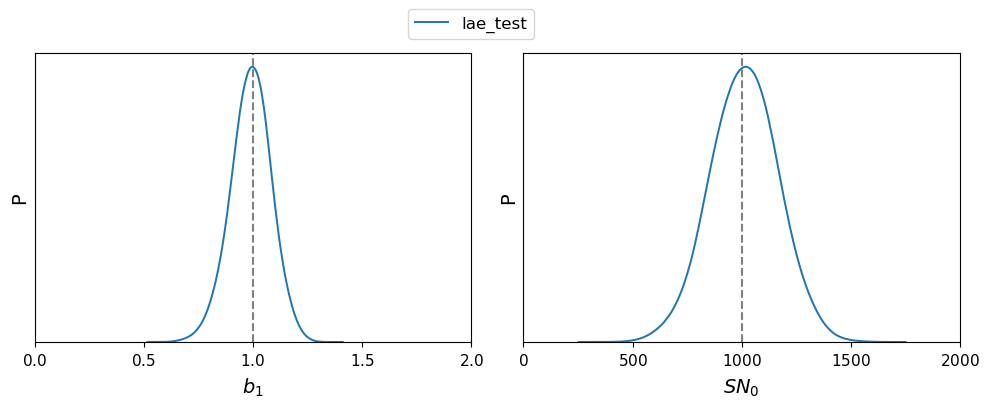

In [10]:
# Look at some 1D posteriors.
if (len(legnd)>3):
    lncol = (len(legnd)+1)//2
else:
    lncol = len(legnd)
g = gdplt.get_single_plotter(width_inch=10)
g.plots_1d(chains,['b1','SN0'],nx=2,normalized=True,\
           colors=clist,\
           legend_labels=legnd,legend_ncol=lncol,\
           constrained_layout=True,\
           xlims=[ [0.0,2.0],[0.0,2000.] ]);
g.subplots[0,0].axvline(1.00,color='grey',ls='--')
g.subplots[0,1].axvline(1000,color='grey',ls='--')
#
#g.export("posterior_1d.pdf")

In [11]:
# Print some limits.
for cc in chains:
    gstats  = cc.getMargeStats().parWithName('b1')
    lower68 = gstats.limits[0].lower
    lower95 = gstats.limits[1].lower
    upper68 = gstats.limits[0].upper
    upper95 = gstats.limits[1].upper
    print("\n"+cc.getName())
    print(cc.getInlineLatex('b1'))
    print("{:6.3f}<b1<{:6.3f} (68CL)".format(lower68,upper68))
    print("{:6.3f}<b1<{:6.3f} (95CL)".format(lower95,upper95))


lae_test
b_1 = 0.991\pm 0.095
 0.902<b1< 1.087 (68CL)
 0.796<b1< 1.173 (95CL)


## Model class

Let's investigate things using the model class.

In [12]:
info = yaml_load_file(db + "lae_test.yaml")
model= get_model(info)
print(list(model.parameterization.sampled_params()))

[model] *WARNING* Ignored blocks/options: ['sampler', 'output', 'stop_on_error']
['b1', 'b2', 'bs', 'alpha0', 'alpha2', 'SN0', 'SN2']


In [13]:
# Set a fiducial point.
pars = {}
#
pars['b1'] = 1.0
for pref in ['b2','bs','alpha0','alpha2','SN0','SN2']:
    pars[pref] = 0.0

In [14]:
# Force the evaluation of the likelihoods.
model.logposterior(pars)

LogPosterior(logpost=-149.0758089363357, logpriors=[-41.404159804875306], loglikes=array([-107.67164913]), derived=[], finite=False)

In [15]:
# Just so we know what likelihoods we have:
print("Have likelihoods:")
print(model.likelihood.keys())
# and what the models wanted:
#print("Model requested:")
#print(model.requested())

Have likelihoods:
dict_keys(['img_likelihood.FullShapeLikelihood'])


In [16]:
# As an example, print the first 5 entires of the observations.
# This could be anything stored in the likelihood class, e.g. C^{-1}
# or the theory or whatever.
for lik in model.likelihood.keys():
    print(lik,"\n",model.likelihood[lik].obs[:5],"\n")

img_likelihood.FullShapeLikelihood 
 [3.48931943e-06 2.53562086e-06 1.92754738e-06 1.53393795e-06
 1.23771465e-06] 



In [17]:
# Let's look at the best-fit model for the first chain.
cc   = chains[0]
pp   = cc.getParams()
ii   = np.argmin(pp.chi2)
print("Best fit model ",ii," has chi^2=",pp.chi2[ii])
#
pars = {}
for k in model.parameterization.sampled_params():
    pars[k] = cc[k][ii]
print(pars)
#
# Force the evaluation of the likelihoods.
mm = model.logposterior(pars)
print(mm)

Best fit model  23230  has chi^2= 3.1869839e-05
{'b1': 1.0013731, 'b2': 57.214608, 'bs': -2.2007649, 'alpha0': -460.91585, 'alpha2': 333.22181, 'SN0': 999.63136, 'SN2': 42010.688}
LogPosterior(logpost=-45.760881227907454, logpriors=[-45.76046576749481], loglikes=array([-0.00041546]), derived=[], finite=False)


In [18]:
# This tidies up after ourselves, frees up memory, etc.
model.close()

INFO:img_likelihood.fullshapelikelihood:Average evaluation time for img_likelihood.FullShapeLikelihood: 0.00754345 s  (1 evaluations)


[img_likelihood.fullshapelikelihood] Average evaluation time for img_likelihood.FullShapeLikelihood: 0.00754345 s  (1 evaluations)


# The end